<center><h1> CNC MILLING MACHINE TOOL CONDITION CLASSIFICATION MODEL </h1><center>

<h3> Contents </h3><br>

<b>Introduction</b><br>

<b>1.Import libraries</b><br>
<b>2. Data analysis</b><br>
<b>3. Data preprocessing</b><br>
<b>4. Model training</b><br>

<b>Results</b><br>

<center><h2> Introduction </h2></center>

<h3> Goals and Objectives </h3>

The study aims to develop a model for identification of worn and unworn cutting tools. To achieve this goal, a number of objectives were identified, including:<br>
1.Analysis of the existing dataset<br>
2.Determining the type of the model (classification or regression)<br>
3.Engineering of the existing features<br>
4.Creating the best-performance model

<h3> Models and Tools </h3>

During the research the following classification models were used:
    
Decision Tree Classifier<br>
XGBoost Classifier<br>
Random Forest Classifier<br>
KNN Classifier<br>
AdaBoost Classifier<br>
SVC Classifier<br>
Logistic Regression Classifier<br>
Naive Bayes Classifier

<h3> Results </h3>

According to the comparison of train/test accuracy score (differnce is less than 1%) and ROC-AUC (above 97%) for test set <b> Ada Boost Classifier </b> was chosen as the best classification model.

<center><h2> 1. Import libraries </h2></center>

In [1]:
#Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import f1_score, auc, roc_curve
from matplotlib.colors import ListedColormap
from sklearn import preprocessing

import xgboost as xgb
from xgboost import plot_importance
import gc

#Encoder

from sklearn.preprocessing import LabelEncoder

#Scaler

from sklearn.preprocessing import StandardScaler

#Classifiers

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

#GridSearchCV

from sklearn.model_selection import GridSearchCV

In [2]:
#Disable warnings

import warnings
warnings.filterwarnings('ignore')

In [3]:
#Model results list
model_list = list()
train_accuracy_score_list = list()
test_accuracy_score_list = list()
roc_auc_list = list()

<center><h2> 2. Data analysis </h2><center>

In [4]:
#Create dataset from experimental files

frames = list()

results = pd.read_csv('C:/Users/Sergey/Documents/KV_AI_JLM_10/INPUT/train.csv')

for i in range(1, 19):
    exp = '0' + str(i) if i < 10 else str(i)
    
    frame = pd.read_csv('C:/Users/Sergey/Documents/KV_AI_JLM_10/INPUT/experiment_{}.csv'.format(exp))
    
    row = results[results['No'] == i]
    frame['tool_condition'] = 1 if row.iloc[0]['tool_condition'] == 'worn' else 0
    
    frames.append(frame)

In [ ]:
pd.read_csv('../../../INPUT/')

In [5]:
frames[17]

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,...,S1_DCBusVoltage,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,S1_SystemInertia,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,Machining_Process,tool_condition
0,151.0,3.08,0.0,151.0,3.00,0.000,3.48,0.0684,327.0,8.56,...,0.867,323.0,119.0,0.167,12.0,1.0,2.0,3.0,Prep,1
1,152.0,3.20,25.0,152.0,3.00,0.000,3.09,0.0621,327.0,6.74,...,0.937,324.0,119.0,0.179,12.0,1.0,20.0,3.0,Prep,1
2,152.0,3.20,50.0,152.0,3.00,0.000,3.96,0.0796,327.0,8.78,...,0.799,323.0,119.0,0.152,12.0,1.0,20.0,3.0,Prep,1
3,152.0,3.13,50.0,152.0,3.00,0.000,4.70,0.0946,327.0,10.20,...,0.895,323.0,114.0,0.172,12.0,1.0,20.0,3.0,Prep,1
4,153.0,2.97,56.3,153.0,3.00,0.000,5.97,0.1020,327.0,11.30,...,0.854,324.0,120.0,0.162,12.0,1.0,20.0,3.0,Prep,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2248,144.0,-2.30,100.0,144.0,-2.57,0.977,-5.05,0.0732,327.0,9.56,...,0.826,323.0,118.0,0.158,12.0,1.0,57.0,3.0,End,1
2249,144.0,-2.47,25.0,144.0,-2.46,1.080,-5.62,0.0996,327.0,10.30,...,0.971,320.0,119.0,0.187,12.0,1.0,57.0,3.0,End,1
2250,143.0,-2.20,81.2,143.0,-2.35,1.170,-4.42,0.0539,327.0,7.79,...,0.950,322.0,119.0,0.182,12.0,1.0,57.0,3.0,End,1
2251,143.0,-2.05,68.7,143.0,-2.23,1.260,-5.83,0.0809,327.0,8.32,...,0.959,322.0,118.0,0.182,12.0,1.0,57.0,3.0,End,1


In [6]:
df = pd.concat(frames, ignore_index = True)

df

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,...,S1_DCBusVoltage,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,S1_SystemInertia,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,Machining_Process,tool_condition
0,198.0,0.00,0.00,198.0,0.00,0.000000,0.18,0.0207,329.0,2.77,...,2.740000e-19,329.0,0.0,6.960000e-07,12.0,1.0,0.0,50.0,Starting,0
1,198.0,-10.80,-350.00,198.0,-13.60,-358.000000,-10.90,0.1860,328.0,23.30,...,2.740000e-19,328.0,0.0,-5.270000e-07,12.0,1.0,4.0,50.0,Prep,0
2,196.0,-17.80,-6.25,196.0,-17.90,-0.000095,-8.59,0.1400,328.0,30.60,...,2.740000e-19,328.0,0.0,9.100000e-07,12.0,1.0,7.0,50.0,Prep,0
3,194.0,-18.00,0.00,194.0,-17.90,-0.000095,-6.11,0.1300,327.0,30.30,...,2.740000e-19,328.0,0.0,1.070000e-06,12.0,1.0,7.0,50.0,Prep,0
4,193.0,-17.90,-18.80,192.0,-17.90,0.000095,-5.70,0.1140,328.0,30.50,...,2.740000e-19,328.0,0.0,1.960000e-06,12.0,1.0,7.0,50.0,Prep,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25281,144.0,-2.30,100.00,144.0,-2.57,0.977000,-5.05,0.0732,327.0,9.56,...,8.260000e-01,323.0,118.0,1.580000e-01,12.0,1.0,57.0,3.0,End,1
25282,144.0,-2.47,25.00,144.0,-2.46,1.080000,-5.62,0.0996,327.0,10.30,...,9.710000e-01,320.0,119.0,1.870000e-01,12.0,1.0,57.0,3.0,End,1
25283,143.0,-2.20,81.20,143.0,-2.35,1.170000,-4.42,0.0539,327.0,7.79,...,9.500000e-01,322.0,119.0,1.820000e-01,12.0,1.0,57.0,3.0,End,1
25284,143.0,-2.05,68.70,143.0,-2.23,1.260000,-5.83,0.0809,327.0,8.32,...,9.590000e-01,322.0,118.0,1.820000e-01,12.0,1.0,57.0,3.0,End,1


In [7]:
# Show general information about dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25286 entries, 0 to 25285
Data columns (total 49 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   X1_ActualPosition          25286 non-null  float64
 1   X1_ActualVelocity          25286 non-null  float64
 2   X1_ActualAcceleration      25286 non-null  float64
 3   X1_CommandPosition         25286 non-null  float64
 4   X1_CommandVelocity         25286 non-null  float64
 5   X1_CommandAcceleration     25286 non-null  float64
 6   X1_CurrentFeedback         25286 non-null  float64
 7   X1_DCBusVoltage            25286 non-null  float64
 8   X1_OutputCurrent           25286 non-null  float64
 9   X1_OutputVoltage           25286 non-null  float64
 10  X1_OutputPower             25286 non-null  float64
 11  Y1_ActualPosition          25286 non-null  float64
 12  Y1_ActualVelocity          25286 non-null  float64
 13  Y1_ActualAcceleration      25286 non-null  flo

In [8]:
#Define variables

print('Current dataset contains: ',len(df.columns),' variables, including:')
print(list(df.columns))

Current dataset contains:  49  variables, including:
['X1_ActualPosition', 'X1_ActualVelocity', 'X1_ActualAcceleration', 'X1_CommandPosition', 'X1_CommandVelocity', 'X1_CommandAcceleration', 'X1_CurrentFeedback', 'X1_DCBusVoltage', 'X1_OutputCurrent', 'X1_OutputVoltage', 'X1_OutputPower', 'Y1_ActualPosition', 'Y1_ActualVelocity', 'Y1_ActualAcceleration', 'Y1_CommandPosition', 'Y1_CommandVelocity', 'Y1_CommandAcceleration', 'Y1_CurrentFeedback', 'Y1_DCBusVoltage', 'Y1_OutputCurrent', 'Y1_OutputVoltage', 'Y1_OutputPower', 'Z1_ActualPosition', 'Z1_ActualVelocity', 'Z1_ActualAcceleration', 'Z1_CommandPosition', 'Z1_CommandVelocity', 'Z1_CommandAcceleration', 'Z1_CurrentFeedback', 'Z1_DCBusVoltage', 'Z1_OutputCurrent', 'Z1_OutputVoltage', 'S1_ActualPosition', 'S1_ActualVelocity', 'S1_ActualAcceleration', 'S1_CommandPosition', 'S1_CommandVelocity', 'S1_CommandAcceleration', 'S1_CurrentFeedback', 'S1_DCBusVoltage', 'S1_OutputCurrent', 'S1_OutputVoltage', 'S1_OutputPower', 'S1_SystemInertia', 

<h4> Definition of variables: </h4><br>

<u>X1_ActualPosition</u>: actual x position of part (mm)<br>
<u>X1_ActualVelocity</u>: actual x velocity of part (mm/s)<br>
<u>X1_ActualAcceleration</u>: actual x acceleration of part (mm/s/s)<br>
<u>X1_CommandPosition</u>: reference x position of part (mm)<br>
<u>X1_CommandVelocity</u>: reference x velocity of part (mm/s)<br>
<u>X1_CommandAcceleration</u>: reference x acceleration of part (mm/s/s)<br>
<u>X1_CurrentFeedback</u>: current (A)<br>
<u>X1_DCBusVoltage</u>: voltage (V)<br>
<u>X1_OutputCurrent</u>: current (A)<br>
<u>X1_OutputVoltage</u>: voltage (V)<br>
<u>X1_OutputPower</u>: power (kW)<br>

<u>Y1_ActualPosition</u>: actual y position of part (mm)<br>
<u>Y1_ActualVelocity</u>: actual y velocity of part (mm/s)<br>
<u>Y1_ActualAcceleration</u>: actual y acceleration of part (mm/s/s)<br>
<u>Y1_CommandPosition</u>: reference y position of part (mm)<br>
<u>Y1_CommandVelocity</u>: reference y velocity of part (mm/s)<br>
<u>Y1_CommandAcceleration</u>: reference y acceleration of part (mm/s/s)<br>
<u>Y1_CurrentFeedback</u>: current (A)<br>
<u>Y1_DCBusVoltage</u>: voltage (V)<br>
<u>Y1_OutputCurrent</u>: current (A)<br>
<u>Y1_OutputVoltage</u>: voltage (V)<br>
<u>Y1_OutputPower</u>: power (kW)<br>

<u>Z1_ActualPosition</u>: actual z position of part (mm)<br>
<u>Z1_ActualVelocity</u>: actual z velocity of part (mm/s)<br>
<u>Z1_ActualAcceleration</u>: actual z acceleration of part (mm/s/s)<br>
<u>Z1_CommandPosition</u>: reference z position of part (mm)<br>
<u>Z1_CommandVelocity</u>: reference z velocity of part (mm/s)<br>
<u>Z1_CommandAcceleration</u>: reference z acceleration of part (mm/s/s)<br>
<u>Z1_CurrentFeedback</u>: current (A)<br>
<u>Z1_DCBusVoltage</u>: voltage (V)<br>
<u>Z1_OutputCurrent</u>: current (A)<br>
<u>Z1_OutputVoltage</u>: voltage (V)<br>

<u>S1_ActualPosition</u>: actual position of spindle (mm)<br>
<u>S1_ActualVelocity</u>: actual velocity of spindle (mm/s)<br>
<u>S1_ActualAcceleration</u>: actual acceleration of spindle (mm/s/s)<br>
<u>S1_CommandPosition</u>: reference position of spindle (mm)<br>
<u>S1_CommandVelocity</u>: reference velocity of spindle (mm/s)<br>
<u>S1_CommandAcceleration</u>: reference acceleration of spindle (mm/s/s)<br>
<u>S1_CurrentFeedback</u>: current (A)<br>
<u>S1_DCBusVoltage</u>: voltage (V)<br>
<u>S1_OutputCurrent</u>: current (A)<br>
<u>S1_OutputVoltage</u>: voltage (V)<br>
<u>S1_OutputPower</u>: current (A)<br>
<u>S1_SystemInertia</u>: torque inertia (kg*m^2)<br>

<u>M1_CURRENT_PROGRAM_NUMBER</u>: number the program is listed under on the CNC<br>
<u>M1_sequence_number</u>: line of G-code being executed<br>
<u>M1_CURRENT_FEEDRATE</u>: instantaneous feed rate of spindle<br>

<u>Machining_Process</u>: the current machining stage being performed. Includes preparation, tracing up  and down the "S" curve involving different layers, and repositioning of the spindle as it moves through the air to a certain starting point<br>


In current project <b> tool_condition </b> is dependent variable.

In [9]:
df.tool_condition.unique()

array([0, 1], dtype=int64)

The dependent variable contains  2  unique labels: [0 1]
Percentage of "0" labels: 47.37%
Percentage of "1" labels: 52.63%


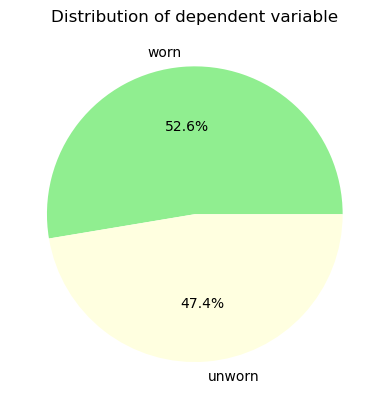

In [10]:
#Analysis of the dependent variable

print('The dependent variable contains ',len(df['tool_condition'].unique()),' unique labels:', df['tool_condition'].unique())

print('Percentage of "0" labels: {:.2%}'.format(list(df['tool_condition']).count(0) / len(df['tool_condition'])))
print('Percentage of "1" labels: {:.2%}'.format(list(df['tool_condition']).count(1) / len(df['tool_condition'])))

target = list()
target.append(list(df['tool_condition']).count(1) / len(df['tool_condition']))
target.append(list(df['tool_condition']).count(0) / len(df['tool_condition']))
target_labels = ['worn', "unworn"]
colors=['lightgreen', 'lightyellow']
plt.pie(target, labels = target_labels, autopct='%.1f%%', colors = colors)
plt.title('Distribution of dependent variable')
plt.show()

The analysis shows that dependent variable has a binary structure which means that classification model can be used to achieve the goal of the project. Moreover, the dataset is balanced.

In [11]:
#Types of independent variables


#numerical: discrete & continuous
discrete = [var for var in df.columns if df[var].dtype != 'O' and var != 'tool_condition' and df[var].nunique() < 10]
continuous = [var for var in df.columns if df[var].dtype != 'O' and var != 'tool_condition' and var not in discrete]

#categorical
categorical = [var for var in df.columns if df[var].dtype == 'O']

print('Current dataset contains:')
print()
print('    {} numerical variables,'.format(len(discrete) + len(continuous)), 'including:')
print('        {} discrete variables:'.format(len(discrete)), list(df[discrete].columns))
print('        {} continuous variables:'.format(len(continuous)), list(df[continuous].columns))
print()
print('    {} categorical variables:'.format(len(categorical)), list(df[categorical].columns))

Current dataset contains:

    47 numerical variables, including:
        8 discrete variables: ['Z1_CurrentFeedback', 'Z1_DCBusVoltage', 'Z1_OutputCurrent', 'Z1_OutputVoltage', 'S1_CommandAcceleration', 'S1_SystemInertia', 'M1_CURRENT_PROGRAM_NUMBER', 'M1_CURRENT_FEEDRATE']
        39 continuous variables: ['X1_ActualPosition', 'X1_ActualVelocity', 'X1_ActualAcceleration', 'X1_CommandPosition', 'X1_CommandVelocity', 'X1_CommandAcceleration', 'X1_CurrentFeedback', 'X1_DCBusVoltage', 'X1_OutputCurrent', 'X1_OutputVoltage', 'X1_OutputPower', 'Y1_ActualPosition', 'Y1_ActualVelocity', 'Y1_ActualAcceleration', 'Y1_CommandPosition', 'Y1_CommandVelocity', 'Y1_CommandAcceleration', 'Y1_CurrentFeedback', 'Y1_DCBusVoltage', 'Y1_OutputCurrent', 'Y1_OutputVoltage', 'Y1_OutputPower', 'Z1_ActualPosition', 'Z1_ActualVelocity', 'Z1_ActualAcceleration', 'Z1_CommandPosition', 'Z1_CommandVelocity', 'Z1_CommandAcceleration', 'S1_ActualPosition', 'S1_ActualVelocity', 'S1_ActualAcceleration', 'S1_CommandPos

In [12]:
# List of variables with missing values

for variable in df:
    percentage_of_missing_values = df[variable].isnull().mean()
    if percentage_of_missing_values > 0:
        print(variable, ' = {:.2%}'.format(percentage_of_missing_values))

The dataset contains both numerical and categorical variables; none of the variables has missing values.

In [13]:
# Show basic statistical information

df.describe().T

,count,mean,std,min,25%,50%,75%,max
X1_ActualPosition,25286.0,159.052045,19.330873,1.410000e+02,1.450000e+02,153.000000,162.000000,198.0000
X1_ActualVelocity,25286.0,-0.288657,5.658260,-2.040000e+01,-2.050000e+00,0.000000,0.200000,50.7000
X1_ActualAcceleration,25286.0,0.094264,93.877623,-1.280000e+03,-3.130000e+01,0.000000,25.000000,1440.0000
X1_CommandPosition,25286.0,159.050700,19.331144,1.410000e+02,1.450000e+02,153.000000,162.000000,198.0000
X1_CommandVelocity,25286.0,-0.283076,5.664309,-2.000000e+01,-2.050000e+00,0.000000,0.000000,50.0000
X1_CommandAcceleration,25286.0,0.253215,72.594951,-1.000000e+03,0.000000e+00,0.000000,0.000000,1000.0000
X1_CurrentFeedback,25286.0,-0.469714,4.220750,-2.340000e+01,-3.930000e+00,-0.666000,3.140000,27.1000
X1_DCBusVoltage,25286.0,0.066031,0.037004,2.780000e-19,4.150000e-02,0.066800,0.091300,0.3800
X1_OutputCurrent,25286.0,326.945859,1.459937,3.200000e+02,3.260000e+02,327.000000,327.000000,331.0000
X1_OutputVoltage,25286.0,7.986942,7.710379,0.000000e+00,2.590000e+00,7.140000,10.200000,75.4000


Variables 'Z1_CurrentFeedback', 'Z1_DCBusVoltage', 'Z1_OutputCurrent', 'Z1_OutputVoltage' and 'S1_SystemInertia' have standard deviation equals 0 which means that labels inside the variable are all the same. This variables can be dropped.

In [14]:
df.drop(columns = [
    'Z1_CurrentFeedback',
    'Z1_DCBusVoltage',
    'Z1_OutputCurrent',
    'Z1_OutputVoltage',
    'S1_SystemInertia'
],inplace = True)

In [15]:
df

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,...,S1_CurrentFeedback,S1_DCBusVoltage,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,Machining_Process,tool_condition
0,198.0,0.00,0.00,198.0,0.00,0.000000,0.18,0.0207,329.0,2.77,...,0.524,2.740000e-19,329.0,0.0,6.960000e-07,1.0,0.0,50.0,Starting,0
1,198.0,-10.80,-350.00,198.0,-13.60,-358.000000,-10.90,0.1860,328.0,23.30,...,-0.288,2.740000e-19,328.0,0.0,-5.270000e-07,1.0,4.0,50.0,Prep,0
2,196.0,-17.80,-6.25,196.0,-17.90,-0.000095,-8.59,0.1400,328.0,30.60,...,0.524,2.740000e-19,328.0,0.0,9.100000e-07,1.0,7.0,50.0,Prep,0
3,194.0,-18.00,0.00,194.0,-17.90,-0.000095,-6.11,0.1300,327.0,30.30,...,-0.180,2.740000e-19,328.0,0.0,1.070000e-06,1.0,7.0,50.0,Prep,0
4,193.0,-17.90,-18.80,192.0,-17.90,0.000095,-5.70,0.1140,328.0,30.50,...,0.226,2.740000e-19,328.0,0.0,1.960000e-06,1.0,7.0,50.0,Prep,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25281,144.0,-2.30,100.00,144.0,-2.57,0.977000,-5.05,0.0732,327.0,9.56,...,20.000,8.260000e-01,323.0,118.0,1.580000e-01,1.0,57.0,3.0,End,1
25282,144.0,-2.47,25.00,144.0,-2.46,1.080000,-5.62,0.0996,327.0,10.30,...,18.800,9.710000e-01,320.0,119.0,1.870000e-01,1.0,57.0,3.0,End,1
25283,143.0,-2.20,81.20,143.0,-2.35,1.170000,-4.42,0.0539,327.0,7.79,...,24.400,9.500000e-01,322.0,119.0,1.820000e-01,1.0,57.0,3.0,End,1
25284,143.0,-2.05,68.70,143.0,-2.23,1.260000,-5.83,0.0809,327.0,8.32,...,21.600,9.590000e-01,322.0,118.0,1.820000e-01,1.0,57.0,3.0,End,1


In [16]:
#Show cardinality

variable_name = df.columns.values.tolist()

perc_cardinality = []
for variable in df:
    number = df[variable].nunique() / len(df)
    perc_cardinality.append(number)
    
table = pd.DataFrame(
{'variable':variable_name,
'% of cardinality':perc_cardinality})

cd_table = table[table['% of cardinality'] > 0].reset_index(drop=True)
cd_table = cd_table.sort_values('% of cardinality', ascending = False)
cd_table.head(10)

,variable,% of cardinality
21,Y1_OutputPower,0.225658
10,X1_OutputPower,0.191213
17,Y1_CurrentFeedback,0.119711
28,S1_ActualPosition,0.110654
31,S1_CommandPosition,0.109903
6,X1_CurrentFeedback,0.094361
5,X1_CommandAcceleration,0.090801
16,Y1_CommandAcceleration,0.088784
38,S1_OutputPower,0.088112
20,Y1_OutputVoltage,0.080835


None of variables has high cardinality.

In [17]:
#Check correlation

df_correlation = df.corr(numeric_only = True)

In [18]:
df_correlation.dropna(thresh = 1, inplace = True)

In [19]:
df_correlation.drop(columns = ['tool_condition'], inplace = True)

<Axes: >

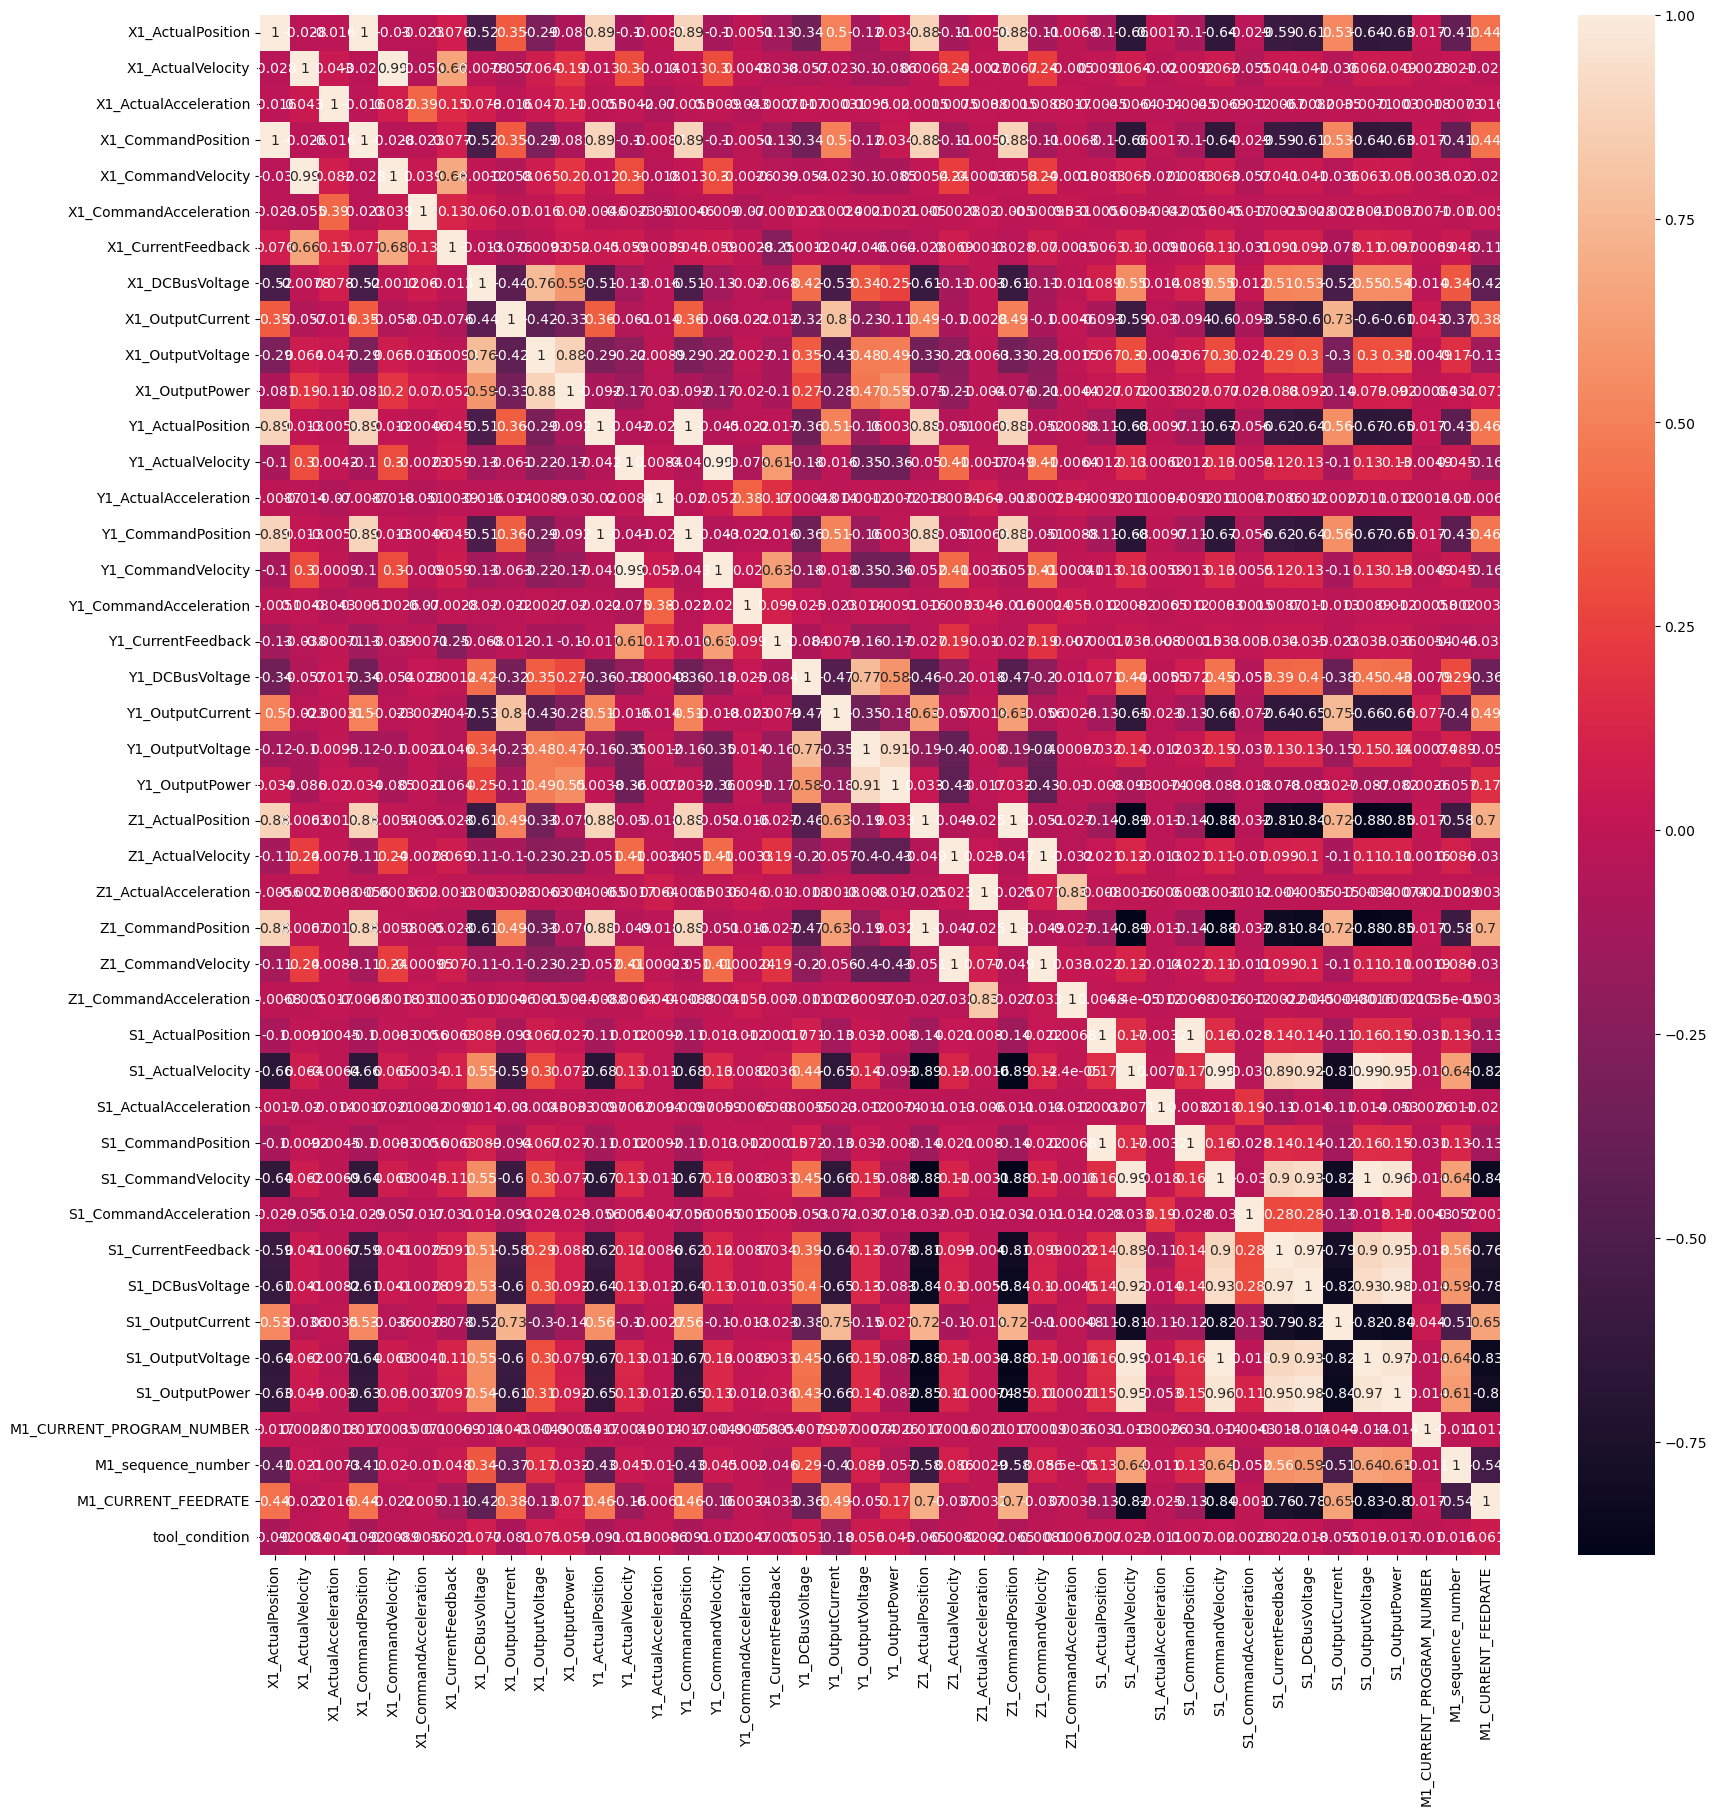

In [20]:
plt.figure(figsize = (20, 20))
sns.heatmap(df_correlation, annot = True)

The following pairs of variables have correlation coeffitient equals to 1:

X1_ActualPosition - X1_CommandPosition<br>
Y1_ActualPosition - Y1_CommandPosition<br>
Z1_ActualPosition - Z1_CommandPosition<br>
Z1_ActualVelocity - Z1_CommandVelocity<br>
S1_ActualPosition - S1_CommandPosition<br>
S1_OutputVoltage - S1_CommandVelocity<br>

According to this information we decided to drop the following variables:<br>
<br>
X1_CommandPosition, Y1_CommandPosition, Z1_CommandPosition, Z1_CommandVelocity, S1_CommandPosition, S1_CommandVelocity


In [22]:
df.drop(columns = [
    'X1_CommandPosition',
    'Y1_CommandPosition',
    'Z1_CommandPosition',
    'Z1_CommandVelocity',
    'S1_CommandPosition',
    'S1_CommandVelocity'
],inplace = True)

In [23]:
df

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,X1_OutputPower,...,S1_CurrentFeedback,S1_DCBusVoltage,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,Machining_Process,tool_condition
0,198.0,0.00,0.00,0.00,0.000000,0.18,0.0207,329.0,2.77,-0.000001,...,0.524,2.740000e-19,329.0,0.0,6.960000e-07,1.0,0.0,50.0,Starting,0
1,198.0,-10.80,-350.00,-13.60,-358.000000,-10.90,0.1860,328.0,23.30,0.004480,...,-0.288,2.740000e-19,328.0,0.0,-5.270000e-07,1.0,4.0,50.0,Prep,0
2,196.0,-17.80,-6.25,-17.90,-0.000095,-8.59,0.1400,328.0,30.60,0.005330,...,0.524,2.740000e-19,328.0,0.0,9.100000e-07,1.0,7.0,50.0,Prep,0
3,194.0,-18.00,0.00,-17.90,-0.000095,-6.11,0.1300,327.0,30.30,0.004890,...,-0.180,2.740000e-19,328.0,0.0,1.070000e-06,1.0,7.0,50.0,Prep,0
4,193.0,-17.90,-18.80,-17.90,0.000095,-5.70,0.1140,328.0,30.50,0.004250,...,0.226,2.740000e-19,328.0,0.0,1.960000e-06,1.0,7.0,50.0,Prep,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25281,144.0,-2.30,100.00,-2.57,0.977000,-5.05,0.0732,327.0,9.56,0.000366,...,20.000,8.260000e-01,323.0,118.0,1.580000e-01,1.0,57.0,3.0,End,1
25282,144.0,-2.47,25.00,-2.46,1.080000,-5.62,0.0996,327.0,10.30,0.000506,...,18.800,9.710000e-01,320.0,119.0,1.870000e-01,1.0,57.0,3.0,End,1
25283,143.0,-2.20,81.20,-2.35,1.170000,-4.42,0.0539,327.0,7.79,0.000215,...,24.400,9.500000e-01,322.0,119.0,1.820000e-01,1.0,57.0,3.0,End,1
25284,143.0,-2.05,68.70,-2.23,1.260000,-5.83,0.0809,327.0,8.32,0.000330,...,21.600,9.590000e-01,322.0,118.0,1.820000e-01,1.0,57.0,3.0,End,1


We also decided to drop 'Machining_Process' variable: it describes the current machining stage being performed, which is irrelevant for the current research.

In [24]:
df.drop(columns = ['Machining_Process'], inplace = True)

In [25]:
df

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,X1_OutputPower,...,S1_CommandAcceleration,S1_CurrentFeedback,S1_DCBusVoltage,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,tool_condition
0,198.0,0.00,0.00,0.00,0.000000,0.18,0.0207,329.0,2.77,-0.000001,...,0.000000e+00,0.524,2.740000e-19,329.0,0.0,6.960000e-07,1.0,0.0,50.0,0
1,198.0,-10.80,-350.00,-13.60,-358.000000,-10.90,0.1860,328.0,23.30,0.004480,...,0.000000e+00,-0.288,2.740000e-19,328.0,0.0,-5.270000e-07,1.0,4.0,50.0,0
2,196.0,-17.80,-6.25,-17.90,-0.000095,-8.59,0.1400,328.0,30.60,0.005330,...,0.000000e+00,0.524,2.740000e-19,328.0,0.0,9.100000e-07,1.0,7.0,50.0,0
3,194.0,-18.00,0.00,-17.90,-0.000095,-6.11,0.1300,327.0,30.30,0.004890,...,0.000000e+00,-0.180,2.740000e-19,328.0,0.0,1.070000e-06,1.0,7.0,50.0,0
4,193.0,-17.90,-18.80,-17.90,0.000095,-5.70,0.1140,328.0,30.50,0.004250,...,0.000000e+00,0.226,2.740000e-19,328.0,0.0,1.960000e-06,1.0,7.0,50.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25281,144.0,-2.30,100.00,-2.57,0.977000,-5.05,0.0732,327.0,9.56,0.000366,...,0.000000e+00,20.000,8.260000e-01,323.0,118.0,1.580000e-01,1.0,57.0,3.0,1
25282,144.0,-2.47,25.00,-2.46,1.080000,-5.62,0.0996,327.0,10.30,0.000506,...,9.540000e-07,18.800,9.710000e-01,320.0,119.0,1.870000e-01,1.0,57.0,3.0,1
25283,143.0,-2.20,81.20,-2.35,1.170000,-4.42,0.0539,327.0,7.79,0.000215,...,-9.540000e-07,24.400,9.500000e-01,322.0,119.0,1.820000e-01,1.0,57.0,3.0,1
25284,143.0,-2.05,68.70,-2.23,1.260000,-5.83,0.0809,327.0,8.32,0.000330,...,0.000000e+00,21.600,9.590000e-01,322.0,118.0,1.820000e-01,1.0,57.0,3.0,1


<center><h2> 3. Data preprocessing </h2><center>

In [26]:
#Divide dataset on train & test parts

X = df.drop(columns = ['tool_condition'], axis = 1)
y = np.array(df['tool_condition'])

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size = 0.3,
    random_state = 100
)

X_train.shape, X_test.shape

((7585, 36), (17701, 36))

In [27]:
#StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<center><h2> 4. Model Training </h2><center>

<h3> Random Forest Classifier </h3>

In [55]:
randomforest_classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state=0)
randomforest_classifier.fit(X_train, y_train)

#GridSearch
parameters = [
    {
        'criterion' : ['gini','entropy','log_loss'],
        'n_estimators':[10,50,100]
     }
]

grid_search = GridSearchCV(
    estimator = randomforest_classifier,
    param_grid = parameters,
    scoring = 'accuracy',
    cv = 10,
    n_jobs = -1
)

grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
print('Best parameters: ', best_parameters)

model = grid_search.best_estimator_

Best parameters:  {'criterion': 'entropy', 'n_estimators': 100}


Accuracy: 97.72%


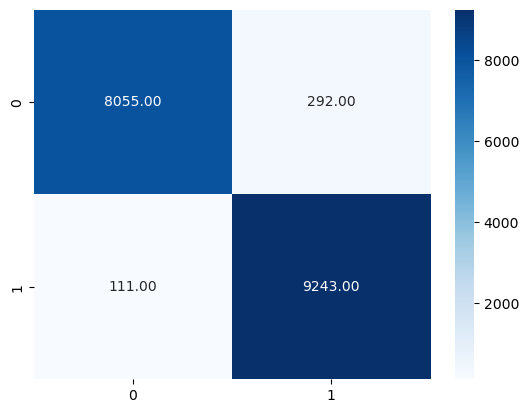

In [28]:
#Implement best parameters
randomforest_classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state=0)
randomforest_classifier.fit(X_train, y_train)

#Evaluate the model

model_list.append('Random Forest Classifier')

y_pred_train = randomforest_classifier.predict(X_train)
accuracy_score_train = accuracy_score(y_train, y_pred_train)
train_accuracy_score_list.append(accuracy_score_train)

y_pred_test = randomforest_classifier.predict(X_test)
accuracy_score_test = accuracy_score(y_test, y_pred_test)
test_accuracy_score_list.append(accuracy_score_test)

cm = confusion_matrix(y_test, y_pred_test)

ax = sns.heatmap(cm, annot=True,fmt='.2f', cmap='Blues')
print('Accuracy: {:.2%}'.format(accuracy_score_test))

In [29]:
probs = randomforest_classifier.predict_proba(X_test)
# save probability for true-positive
probs = probs[:, 1]
# ROC-AUC
auc = roc_auc_score(y_test, probs)
print('Model ROC-AUC = {:.2%}'.format(auc))
roc_auc_list.append(auc)

Model ROC-AUC = 99.77%


In [30]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      8347
           1       0.97      0.99      0.98      9354

    accuracy                           0.98     17701
   macro avg       0.98      0.98      0.98     17701
weighted avg       0.98      0.98      0.98     17701



<h3> Decision Tree Classifier </h3>

In [59]:
decisiontree_classifier = DecisionTreeClassifier(criterion='entropy', random_state=0)
decisiontree_classifier.fit(X_train, y_train)

#GridSearch
parameters = [
    {
        'criterion' : ['gini','entropy','log_loss'],
        'splitter' : ['best','random']
     }
]

grid_search = GridSearchCV(
    estimator = decisiontree_classifier,
    param_grid = parameters,
    scoring = 'accuracy',
    cv = 10,
    n_jobs = -1
)

grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
print('Best parameters: ', best_parameters)

model = grid_search.best_estimator_

Best parameters:  {'criterion': 'entropy', 'splitter': 'best'}


Accuracy: 97.63%


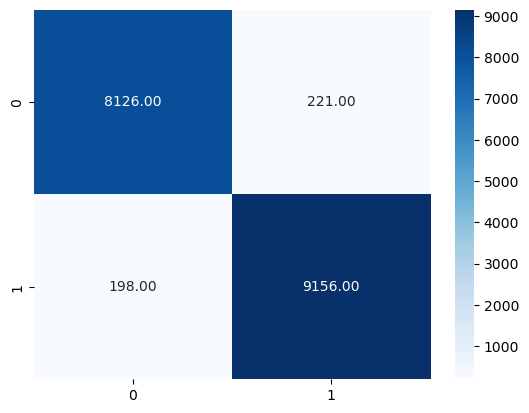

In [31]:
#Implement best parameters
decisiontree_classifier = DecisionTreeClassifier(criterion= 'entropy', splitter = 'best', random_state=0)
decisiontree_classifier.fit(X_train, y_train)

#Evaluate the model

model_list.append('Decision Tree Classifier')

y_pred_train = decisiontree_classifier.predict(X_train)
accuracy_score_train = accuracy_score(y_train, y_pred_train)
train_accuracy_score_list.append(accuracy_score_train)

y_pred_test = decisiontree_classifier.predict(X_test)
accuracy_score_test = accuracy_score(y_test, y_pred_test)
test_accuracy_score_list.append(accuracy_score_test)

cm = confusion_matrix(y_test, y_pred_test)

ax = sns.heatmap(cm, annot=True,fmt='.2f', cmap='Blues')
print('Accuracy: {:.2%}'.format(accuracy_score_test))

In [32]:
probs = decisiontree_classifier.predict_proba(X_test)
# save probability for true-positive
probs = probs[:, 1]
# ROC-AUC
auc = roc_auc_score(y_test, probs)
print('Model ROC-AUC = {:.2%}'.format(auc))
roc_auc_list.append(auc)

Model ROC-AUC = 97.62%


In [33]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      8347
           1       0.98      0.98      0.98      9354

    accuracy                           0.98     17701
   macro avg       0.98      0.98      0.98     17701
weighted avg       0.98      0.98      0.98     17701



<h3> SVC </h3>

In [63]:
svc_classifier = SVC(kernel = 'linear', probability = True, random_state=0)
svc_classifier.fit(X_train, y_train)

#GridSearch
parameters = [
    {
        'C':[0.25, 0.5, 0.75, 1],
        'kernel':['linear', 'rbf']
     }
]

grid_search = GridSearchCV(
    estimator = svc_classifier,
    param_grid = parameters,
    scoring = 'accuracy',
    cv = 10,
    n_jobs = -1
)

grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
print('Best parameters: ', best_parameters)

model = grid_search.best_estimator_

Best parameters:  {'C': 1, 'kernel': 'rbf'}


Accuracy: 68.37%


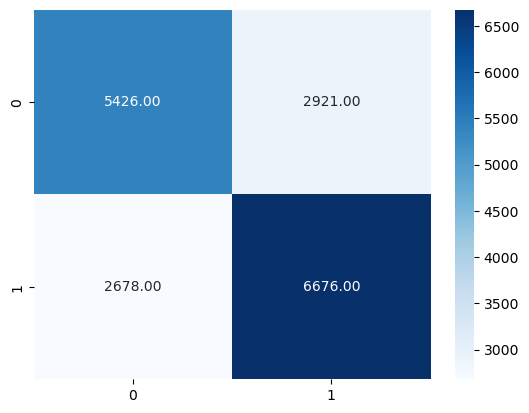

In [34]:
#Implement best parameters
svc_classifier = SVC(C = 1, kernel = 'rbf', probability = True, random_state=0)
svc_classifier.fit(X_train, y_train)

#Evaluate the model

model_list.append('SVC')

y_pred_train = svc_classifier.predict(X_train)
accuracy_score_train = accuracy_score(y_train, y_pred_train)
train_accuracy_score_list.append(accuracy_score_train)

y_pred_test = svc_classifier.predict(X_test)
accuracy_score_test = accuracy_score(y_test, y_pred_test)
test_accuracy_score_list.append(accuracy_score_test)

cm = confusion_matrix(y_test, y_pred_test)

ax = sns.heatmap(cm, annot=True,fmt='.2f', cmap='Blues')
print('Accuracy: {:.2%}'.format(accuracy_score_test))

In [35]:
probs = svc_classifier.predict_proba(X_test)
# save probability for true-positive
probs = probs[:, 1]
# ROC-AUC
auc = roc_auc_score(y_test, probs)
print('Model ROC-AUC = {:.2%}'.format(auc))
roc_auc_list.append(auc)

Model ROC-AUC = 75.71%


In [36]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.67      0.65      0.66      8347
           1       0.70      0.71      0.70      9354

    accuracy                           0.68     17701
   macro avg       0.68      0.68      0.68     17701
weighted avg       0.68      0.68      0.68     17701



<h3> KNN </h3>

In [67]:
knn_classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
knn_classifier.fit(X_train, y_train)

#GridSearch
parameters = [
    {
        'weights':['uniform','distance'],
        'algorithm':['ball_tree','kd_tree']
     }
]

grid_search = GridSearchCV(
    estimator = knn_classifier,
    param_grid = parameters,
    scoring = 'accuracy',
    cv = 10,
    n_jobs = -1
)

grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
print('Best parameters: ', best_parameters)

model = grid_search.best_estimator_

Best parameters:  {'algorithm': 'ball_tree', 'weights': 'distance'}


Accuracy: 77.16%


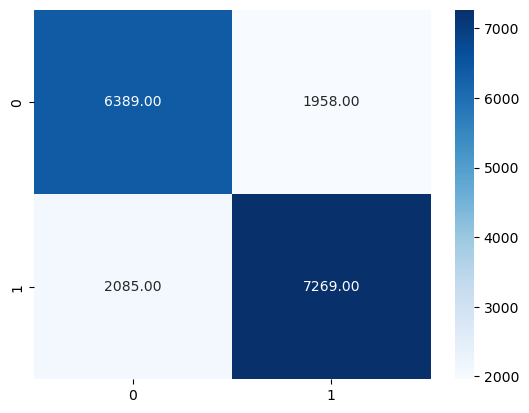

In [37]:
#Implement best parameters
knn_classifier = KNeighborsClassifier(weights = 'distance', algorithm = 'ball_tree', n_neighbors = 5, metric = 'minkowski', p = 2)
knn_classifier.fit(X_train, y_train)

#Evaluate the model

model_list.append('KNN Classifier')

y_pred_train = knn_classifier.predict(X_train)
accuracy_score_train = accuracy_score(y_train, y_pred_train)
train_accuracy_score_list.append(accuracy_score_train)

y_pred_test = knn_classifier.predict(X_test)
accuracy_score_test = accuracy_score(y_test, y_pred_test)
test_accuracy_score_list.append(accuracy_score_test)

cm = confusion_matrix(y_test, y_pred_test)

ax = sns.heatmap(cm, annot=True,fmt='.2f', cmap='Blues')
print('Accuracy: {:.2%}'.format(accuracy_score_test))

In [38]:
probs = knn_classifier.predict_proba(X_test)
# save probability for true-positive
probs = probs[:, 1]
# ROC-AUC
auc = roc_auc_score(y_test, probs)
print('Model ROC-AUC = {:.2%}'.format(auc))
roc_auc_list.append(auc)

Model ROC-AUC = 86.95%


In [39]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76      8347
           1       0.79      0.78      0.78      9354

    accuracy                           0.77     17701
   macro avg       0.77      0.77      0.77     17701
weighted avg       0.77      0.77      0.77     17701



<h3> Logistic Regression </h3>

Accuracy: 56.19%


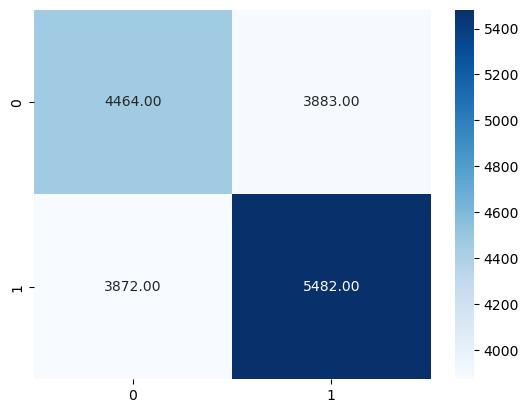

In [40]:
lr_classifier = LogisticRegression(random_state = 0)
lr_classifier.fit(X_train, y_train)

#Evaluate the model

model_list.append('Logistic Regression Classifier')

y_pred_train = lr_classifier.predict(X_train)
accuracy_score_train = accuracy_score(y_train, y_pred_train)
train_accuracy_score_list.append(accuracy_score_train)

y_pred_test = lr_classifier.predict(X_test)
accuracy_score_test = accuracy_score(y_test, y_pred_test)
test_accuracy_score_list.append(accuracy_score_test)

cm = confusion_matrix(y_test, y_pred_test)

ax = sns.heatmap(cm, annot=True,fmt='.2f', cmap='Blues')
print('Accuracy: {:.2%}'.format(accuracy_score_test))

In [41]:
probs = lr_classifier.predict_proba(X_test)
# save probability for true-positive
probs = probs[:, 1]
# ROC-AUC
auc = roc_auc_score(y_test, probs)
print('Model ROC-AUC = {:.2%}'.format(auc))
roc_auc_list.append(auc)

Model ROC-AUC = 62.92%


In [42]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.54      0.53      0.54      8347
           1       0.59      0.59      0.59      9354

    accuracy                           0.56     17701
   macro avg       0.56      0.56      0.56     17701
weighted avg       0.56      0.56      0.56     17701



<h3> Naive Bayes </h3>

Accuracy: 57.24%


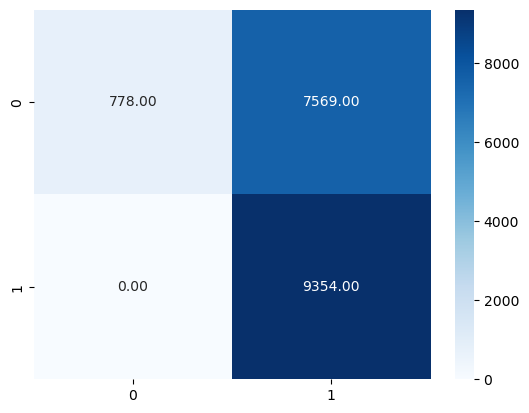

In [43]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

#Evaluate the model

model_list.append('Naive Bayese Classifier')

y_pred_train = nb_classifier.predict(X_train)
accuracy_score_train = accuracy_score(y_train, y_pred_train)
train_accuracy_score_list.append(accuracy_score_train)

y_pred_test = nb_classifier.predict(X_test)
accuracy_score_test = accuracy_score(y_test, y_pred_test)
test_accuracy_score_list.append(accuracy_score_test)

cm = confusion_matrix(y_test, y_pred_test)

ax = sns.heatmap(cm, annot=True,fmt='.2f', cmap='Blues')
print('Accuracy: {:.2%}'.format(accuracy_score_test))

In [44]:
probs = nb_classifier.predict_proba(X_test)
# save probability for true-positive
probs = probs[:, 1]
# ROC-AUC
auc = roc_auc_score(y_test, probs)
print('Model ROC-AUC = {:.2%}'.format(auc))
roc_auc_list.append(auc)

Model ROC-AUC = 56.30%


In [45]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.09      0.17      8347
           1       0.55      1.00      0.71      9354

    accuracy                           0.57     17701
   macro avg       0.78      0.55      0.44     17701
weighted avg       0.76      0.57      0.46     17701



<h3> XG Boost </h3>

Accuracy: 98.74%


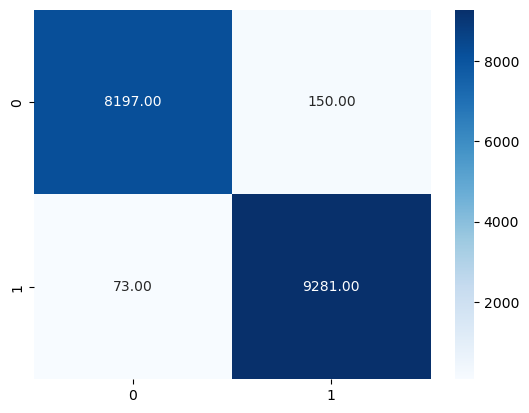

In [46]:
xgb_classifier = XGBClassifier(random_state = 0)
xgb_classifier.fit(X_train, y_train)

#Evaluate the model

model_list.append('XG Boost Classifier')

y_pred_train = xgb_classifier.predict(X_train)
accuracy_score_train = accuracy_score(y_train, y_pred_train)
train_accuracy_score_list.append(accuracy_score_train)

y_pred_test = xgb_classifier.predict(X_test)
accuracy_score_test = accuracy_score(y_test, y_pred_test)
test_accuracy_score_list.append(accuracy_score_test)

cm = confusion_matrix(y_test, y_pred_test)

ax = sns.heatmap(cm, annot=True,fmt='.2f', cmap='Blues')
print('Accuracy: {:.2%}'.format(accuracy_score_test))

In [47]:
probs = xgb_classifier.predict_proba(X_test)
# save probability for true-positive
probs = probs[:, 1]
# ROC-AUC
auc = roc_auc_score(y_test, probs)
print('Model ROC-AUC = {:.2%}'.format(auc))
roc_auc_list.append(auc)

Model ROC-AUC = 99.90%


In [48]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      8347
           1       0.98      0.99      0.99      9354

    accuracy                           0.99     17701
   macro avg       0.99      0.99      0.99     17701
weighted avg       0.99      0.99      0.99     17701



<h3> Ada Boost </h3>

Accuracy: 89.76%


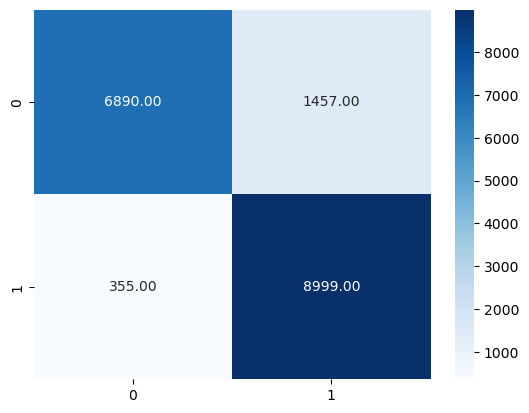

In [49]:
ab_classifier = AdaBoostClassifier(n_estimators=50, learning_rate=0.5, algorithm='SAMME.R', random_state=1)
ab_classifier.fit(X_train, y_train)

#Evaluate the model

model_list.append('Ada Boost Classifier')

y_pred_train = ab_classifier.predict(X_train)
accuracy_score_train = accuracy_score(y_train, y_pred_train)
train_accuracy_score_list.append(accuracy_score_train)

y_pred_test = ab_classifier.predict(X_test)
accuracy_score_test = accuracy_score(y_test, y_pred_test)
test_accuracy_score_list.append(accuracy_score_test)

cm = confusion_matrix(y_test, y_pred_test)

ax = sns.heatmap(cm, annot=True,fmt='.2f', cmap='Blues')
print('Accuracy: {:.2%}'.format(accuracy_score_test))

In [50]:
probs = ab_classifier.predict_proba(X_test)
# save probability for true-positive
probs = probs[:, 1]
# ROC-AUC
auc = roc_auc_score(y_test, probs)
print('Model ROC-AUC = {:.2%}'.format(auc))
roc_auc_list.append(auc)

Model ROC-AUC = 97.74%


In [51]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.95      0.83      0.88      8347
           1       0.86      0.96      0.91      9354

    accuracy                           0.90     17701
   macro avg       0.91      0.89      0.90     17701
weighted avg       0.90      0.90      0.90     17701



<center><h2> RESULTS </h2><center>

In [52]:
results = pd.DataFrame({'model': model_list,
                       'train_accuracy_score': train_accuracy_score_list,
                       'test_accuracy_score': test_accuracy_score_list,
                       'roc-auc_score': roc_auc_list}
                       )

In [53]:
results.sort_values(by = 'roc-auc_score', ascending = False)

,model,train_accuracy_score,test_accuracy_score,roc-auc_score
6,XG Boost Classifier,1.000000,0.987402,0.999009
0,Random Forest Classifier,1.000000,0.977233,0.997670
7,Ada Boost Classifier,0.905867,0.897633,0.977415
1,Decision Tree Classifier,1.000000,0.976329,0.976178
3,KNN Classifier,1.000000,0.771595,0.869495
2,SVC,0.714436,0.683690,0.757122
4,Logistic Regression Classifier,0.557680,0.561889,0.629190
5,Naive Bayese Classifier,0.569018,0.572397,0.563019


(0.55, 1.05)

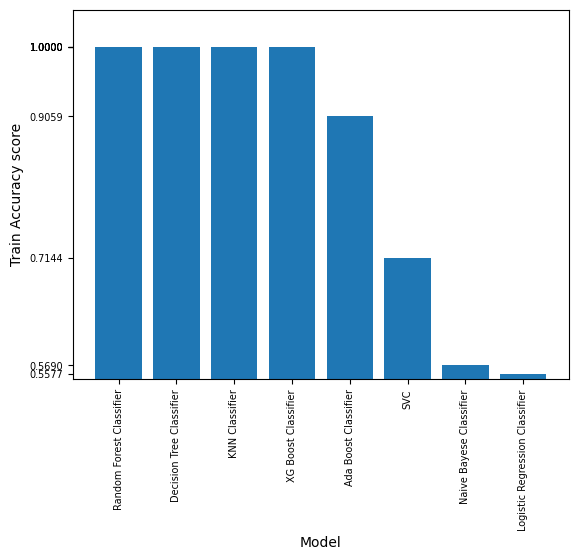

In [55]:
results_plot = results.sort_values('train_accuracy_score',ascending=False)
plt.bar(results_plot['model'], results_plot['train_accuracy_score'])
plt.xticks(results_plot['model'],rotation = 90, fontsize = 7)
plt.yticks(results_plot['train_accuracy_score'], fontsize = 7)
plt.xlabel('Model')
plt.ylabel('Train Accuracy score')
plt.ylim(0.55, 1.05)

(0.55, 1.05)

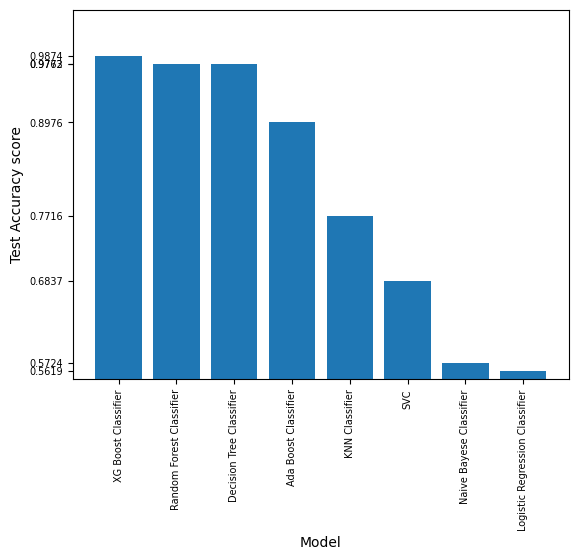

In [59]:
results_plot = results.sort_values('test_accuracy_score',ascending=False)
plt.bar(results_plot['model'], results_plot['test_accuracy_score'])
plt.xticks(results_plot['model'],rotation = 90, fontsize = 7)
plt.yticks(results_plot['test_accuracy_score'], fontsize = 7)
plt.xlabel('Model')
plt.ylabel('Test Accuracy score')
plt.ylim(0.55, 1.05)

(0.55, 1.05)

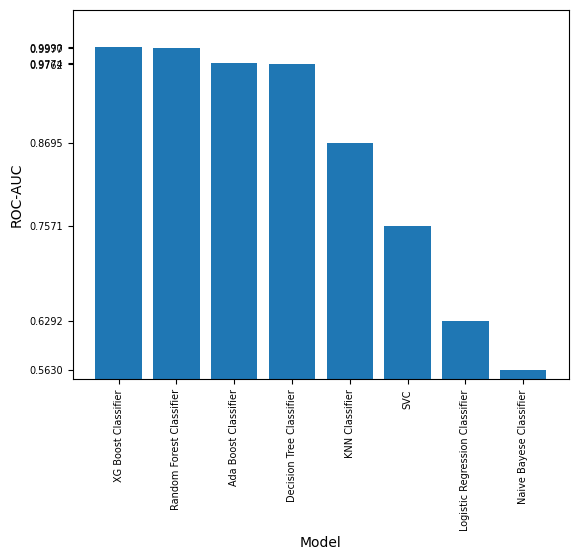

In [61]:
results_plot = results.sort_values('roc-auc_score',ascending=False)
plt.bar(results_plot['model'], results_plot['roc-auc_score'])
plt.xticks(results_plot['model'],rotation = 90, fontsize = 7)
plt.yticks(results_plot['roc-auc_score'], fontsize = 7)
plt.xlabel('Model')
plt.ylabel('ROC-AUC')
plt.ylim(0.55, 1.05)

According to the comparison of train/test accuracy score (differnce is less than 1%) and ROC-AUC (above 97%) for test set <b> Ada Boost Classifier </b> was chosen as the best classification model.